# Лабораторная работа №6 "Применение сверточных нейронных сетей (многоклассовая классификация)"

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from google.colab import files
from google.colab import drive

import zipfile
import pathlib
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/6/'
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Задание 1.
Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.


In [4]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 4.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=81e8f4506863bf25ed9fe3856f4ec521ae311635f9b0e096d0cad403ea023c8e
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"presniatski","key":"285b0065530242871fcbdfefd4a841a4"}'}

In [ ]:
!chmod 600 kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle

In [7]:
!kaggle datasets download -d datamunge/sign-language-mnist

 66% 41.0M/62.6M [00:00<00:00, 90.9MB/s]
100% 62.6M/62.6M [00:00<00:00, 140MB/s] 


In [12]:
!unzip sign-language-mnist.zip
!cp sign_mnist_train.csv /content/drive/'My Drive'/'Colab Notebooks'/6/
!cp sign_mnist_test.csv /content/drive/'My Drive'/'Colab Notebooks'/6/

Archive:  sign-language-mnist.zip
replace amer_sign2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


После скачивания, распаковки и сохранения файлов на Google Drive начнём предобработку данных.

In [ ]:
train_df = pd.read_csv(f'{DRIVE_DIR}sign_mnist_train.csv')
test_df = pd.read_csv(f'{DRIVE_DIR}sign_mnist_test.csv')

In [5]:
print(f'Train dataframe shape: {train_df.shape}')
print(f'Test dataframe shape: {test_df.shape}')

Train dataframe shape: (27455, 785)
Test dataframe shape: (7172, 785)


In [ ]:
BATCH_SIZE = 128
IMG_HEIGHT = 28
IMG_WIDTH = 28

In [ ]:
def convert_df_to_np(df):
    x = df.drop(columns=['label']).values.reshape((-1, IMG_HEIGHT, IMG_WIDTH, 1))
    y = df['label'].values
    return x, y

In [ ]:
x, y = convert_df_to_np(train_df)
x_test, y_test = convert_df_to_np(test_df)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

total_train = len(y_train)
total_valid = len(y_valid)
total_test = len(y_test)

In [9]:
print(f'Train items number: {total_train}')
print(f'Valid items number: {total_valid}')
print(f'Test items number: {total_test}')

Train items number: 21964
Valid items number: 5491
Test items number: 7172


In [ ]:
def create_generator(x, y=None, batch_size=BATCH_SIZE):
    image_gen = ImageDataGenerator(rescale=1./255)
    data_gen = image_gen.flow(x=x, y=y, batch_size=batch_size)
    return data_gen

In [ ]:
train_data_gen = create_generator(x_train, y_train)
valid_data_gen = create_generator(x_valid, y_valid)
test_data_gen = create_generator(x_test, y_test)

In [ ]:
def show_images(data_gen):
    image_batch, label_batch = next(iter(data_gen))
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n, :, :, 0], cmap='gray')
        plt.title(chr(ord('A') + label_batch[n]))
        plt.axis('off')

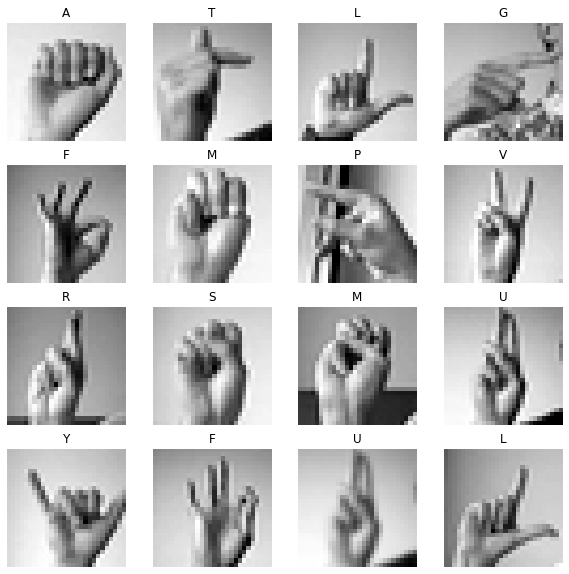

In [13]:
show_images(train_data_gen)

### Задание 2.
Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?


In [ ]:
def build_model():
    model = keras.models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(25, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [57]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)         

In [ ]:
def show_history(history):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [59]:
EPOCHS = 10

lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)
checkpoint = ModelCheckpoint(f'{DRIVE_DIR}cnn_sign_mnist_weights.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

history = model.fit(
    train_data_gen, 
    epochs=EPOCHS,
    workers=4,
    validation_data=valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    steps_per_epoch=total_train // BATCH_SIZE,
    callbacks=[lr_reduction, checkpoint]
)


Epoch 1/10
166/171 [============================>.] - ETA: 0s - loss: 2.5365 - accuracy: 0.3443
Epoch 00001: val_accuracy improved from -inf to 0.04512, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_sign_mnist_weights.h5
171/171 [==============================] - 2s 14ms/step - loss: 2.5236 - accuracy: 0.3474 - val_loss: 3.9222 - val_accuracy: 0.0451 - lr: 0.0010
Epoch 2/10
169/171 [============================>.] - ETA: 0s - loss: 1.3987 - accuracy: 0.5599
Epoch 00002: val_accuracy improved from 0.04512 to 0.18311, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_sign_mnist_weights.h5
171/171 [==============================] - 2s 11ms/step - loss: 1.3922 - accuracy: 0.5618 - val_loss: 2.8299 - val_accuracy: 0.1831 - lr: 0.0010
Epoch 3/10
167/171 [============================>.] - ETA: 0s - loss: 0.4934 - accuracy: 0.8462
Epoch 00003: val_accuracy improved from 0.18311 to 0.69382, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_sign_mnist_weig

In [60]:
eval_model = keras.models.load_model(f'{DRIVE_DIR}cnn_sign_mnist_weights.h5')
eval_model.evaluate(test_data_gen, steps=total_test // BATCH_SIZE, workers=4)

56/56 [==============================] - 1s 9ms/step - loss: 0.1778 - accuracy: 0.9495


[0.1777963489294052, 0.949460506439209]

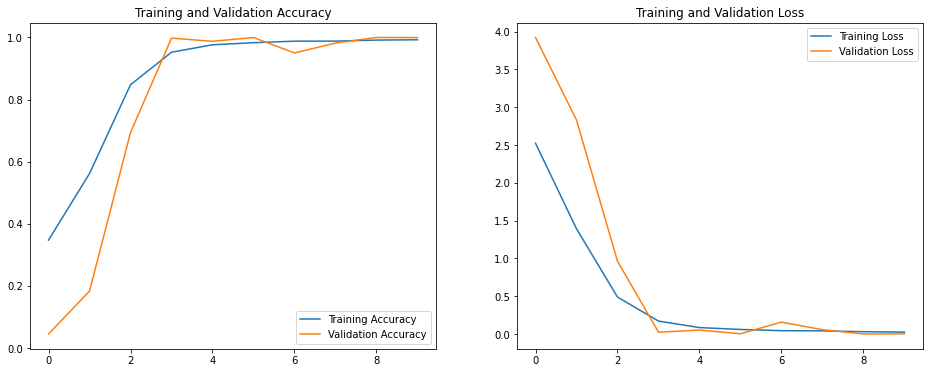

In [61]:
show_history(history)

Полученная точность составила 94.9% на контрольной выборке. Была применена архитектура с 4-мя блоками: три свёрточных блока и один полносвязный блок. Для всех блоков применяется пуллинг, батч нормализация и дропаут.

### Задание 3.
Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 

In [ ]:
def create_augmented_generator(x, y=None, batch_size=BATCH_SIZE):
    img_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.8, 1.2),
        horizontal_flip=True,
    )
    data_gen = img_gen.flow(x=x, y=y, batch_size=batch_size)
    return data_gen

In [ ]:
train_augmented_data_gen = create_augmented_generator(x_train, y_train)

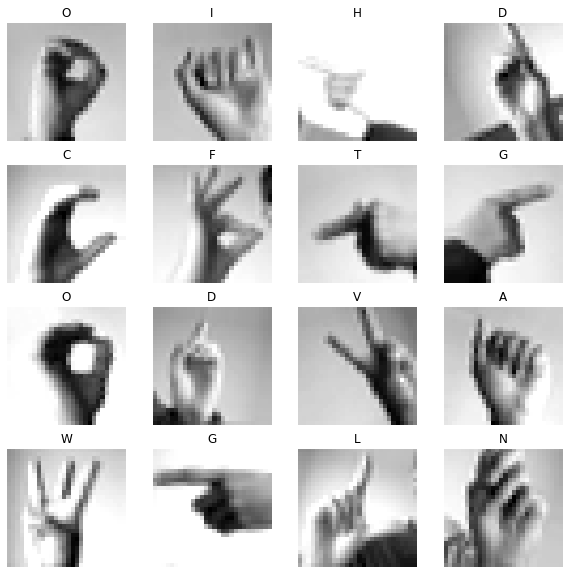

In [65]:
show_images(train_augmented_data_gen)

In [66]:
EPOCHS = 15

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)

checkpoint = ModelCheckpoint(f'{DRIVE_DIR}cnn_augmented_sign_mnist_weights.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

history = model.fit(
    train_augmented_data_gen, 
    epochs=EPOCHS,
    steps_per_epoch=total_train * 2 // BATCH_SIZE,
    workers=4,
    validation_data=valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    callbacks=[lr_reduction, checkpoint]
)

Epoch 1/15
343/343 [==============================] - ETA: 0s - loss: 1.3645 - accuracy: 0.5961
Epoch 00001: val_accuracy improved from -inf to 0.92914, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_augmented_sign_mnist_weights.h5
343/343 [==============================] - 30s 88ms/step - loss: 1.3645 - accuracy: 0.5961 - val_loss: 0.2326 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 2/15
342/343 [============================>.] - ETA: 0s - loss: 0.7795 - accuracy: 0.7355
Epoch 00002: val_accuracy improved from 0.92914 to 0.94443, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_augmented_sign_mnist_weights.h5
343/343 [==============================] - 30s 89ms/step - loss: 0.7793 - accuracy: 0.7355 - val_loss: 0.1839 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 3/15
342/343 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.7825
Epoch 00003: val_accuracy did not improve from 0.94443
343/343 [==============================] - 30s 86ms/step - l

In [33]:
eval_model = keras.models.load_model(f'{DRIVE_DIR}cnn_augmented_sign_mnist_weights.h5')
eval_model.evaluate(test_data_gen, steps=total_test // BATCH_SIZE, workers=4)

56/56 [==============================] - 1s 13ms/step - loss: 0.0848 - accuracy: 0.9784


[0.08479136973619461, 0.9784213304519653]

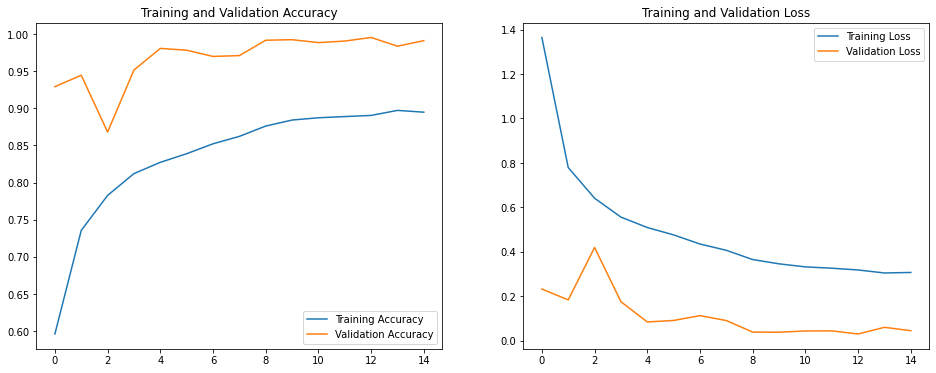

In [68]:
show_history(history)

С применением дополнений данных мы также увеличили количество элементов в обучающей выборке. Качество классификатора на контрольной выборке выросло на 2.9% и составило 97.8%. Однако, дополнение данных сказалось на точности на обучающей выборке.

### Задание 4.
Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Можно ли было обойтись без него?
Какой максимальный результат удалось получить на контрольной выборке?

In [ ]:
def create_generator_for_transfer_learning(x, y=None, target_size=None, aug=False, batch_size=BATCH_SIZE):
    assert isinstance(target_size, tuple) and len(target_size) == 2, "target_size should be a tuple consisting of 2 elements"
    if aug:
        img_gen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            brightness_range=(0.8, 1.2),
            horizontal_flip=True,
        )
    else:
        img_gen = ImageDataGenerator(rescale=1./255)

    x = tf.image.resize(x, target_size)
    x = tf.image.grayscale_to_rgb(x)
    data_gen = img_gen.flow(x=x, y=y, batch_size=batch_size)
    return data_gen

In [ ]:
def show_predictions(model, test_gen):
    x_batch, y_batch = next(iter(test_gen))
    n_samples = 25
    preds = model.predict(x_batch)
    real_preds = np.argmax(preds, axis=1)
    fig = plt.figure(figsize=(16, 12))

    def to_char(p):
        return chr(ord('A') + int(p))

    for i in range(1, 26):
        ax = fig.add_subplot(5, 5, i)
        ax.set_title(f'Predicted: {to_char(real_preds[i - 1])}, real: {to_char(y_batch[i - 1])}')
        ax.set_axis_off()
        plt.imshow(x_batch[i - 1])

    plt.show()

Для начала поэкспериментируем с сетью **VGG16**.

Эта модель имеет размерность на входном слое не менее 32x32, поэтому сначала нам необходимо изменить размер изображений (т.к. сейчас они имеют размерность 28x28). Также, необходимо преобразовать картинки из формата grayscale в формат rgb.

In [ ]:
VGG16_IMG_HEIGHT = IMG_HEIGHT * 2
VGG16_IMG_WIDTH = IMG_WIDTH * 2

In [ ]:
vgg16_train_data_gen = create_generator_for_transfer_learning(x_train, y_train, aug=True, target_size=(VGG16_IMG_HEIGHT, VGG16_IMG_WIDTH))
vgg16_valid_data_gen = create_generator_for_transfer_learning(x_valid, y_valid, target_size=(VGG16_IMG_HEIGHT, VGG16_IMG_WIDTH))
vgg16_test_data_gen = create_generator_for_transfer_learning(x_test, y_test, target_size=(VGG16_IMG_HEIGHT, VGG16_IMG_WIDTH))

In [48]:
vgg16_net = keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(VGG16_IMG_HEIGHT, VGG16_IMG_WIDTH, 3))
vgg16_net.trainable = False

model = keras.models.Sequential()
model.add(vgg16_net)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(25, activation='softmax'))

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                25625     
Total params: 15,265,625
Trainable params: 550,937
Non-trainable params: 14,714,688
_________________________________________________________________


In [49]:
EPOCHS = 15

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)

checkpoint = ModelCheckpoint(f'{DRIVE_DIR}cnn_vgg16_sign_mnist_weights.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

history = model.fit(
    vgg16_train_data_gen, 
    epochs=EPOCHS,
    steps_per_epoch=total_train * 2 // BATCH_SIZE,
    workers=4,
    validation_data=vgg16_valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    callbacks=[lr_reduction, checkpoint]
)

Epoch 1/15
343/343 [==============================] - ETA: 0s - loss: 1.3382 - accuracy: 0.5866
Epoch 00001: val_accuracy improved from -inf to 0.83278, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_vgg16_sign_mnist_weights.h5
343/343 [==============================] - 57s 165ms/step - loss: 1.3382 - accuracy: 0.5866 - val_loss: 0.6546 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 2/15
343/343 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.7637
Epoch 00002: val_accuracy improved from 0.83278 to 0.88514, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_vgg16_sign_mnist_weights.h5
343/343 [==============================] - 56s 163ms/step - loss: 0.7177 - accuracy: 0.7637 - val_loss: 0.4330 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 3/15
343/343 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.8110
Epoch 00003: val_accuracy improved from 0.88514 to 0.91143, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn

In [88]:
eval_model = keras.models.load_model(f'{DRIVE_DIR}cnn_vgg16_sign_mnist_weights.h5')
eval_model.evaluate(vgg16_test_data_gen, steps=total_test // BATCH_SIZE, workers=4)

56/56 [==============================] - 2s 32ms/step - loss: 0.1398 - accuracy: 0.9614


[0.13984635472297668, 0.9613855481147766]

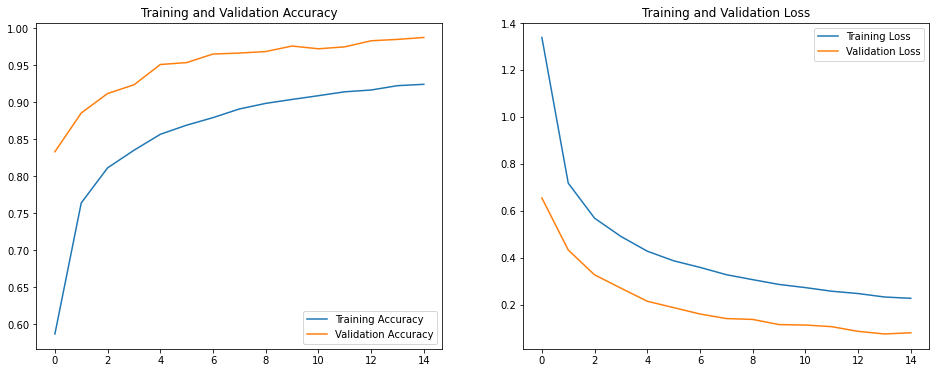

In [54]:
show_history(history)

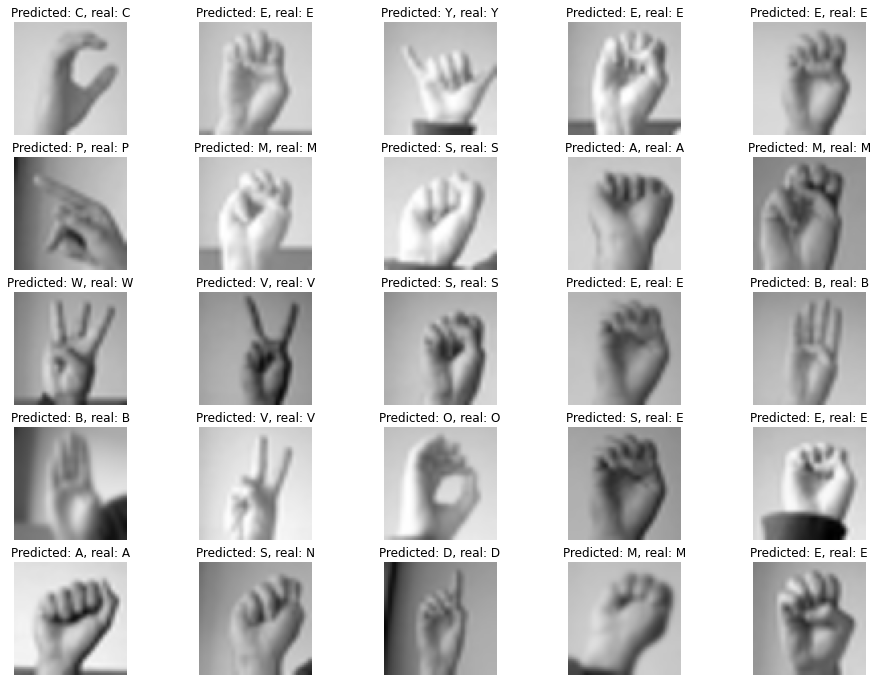

In [83]:
show_predictions(eval_model, vgg16_test_data_gen)

Точность классификатора на контрольной выборке составила 96.1%, что несколько меньше, чем мы получали ранее. Однако, из графика мы видим, что ошибка продолжает падать, а точность расти. Это значит, что если увеличить количество эпох до 50-100, то, вероятно, точность сможет неплохо вырасти.

Но очевидное преимущество архитектуры прошлой модели, это то, что мы сумели добиться большей точности за меньшее время.

Попробуем теперь применить тонкую настройку для этой сети. Запретим обучаться всем слоям кроме последнего блока свёртки.

In [50]:
vgg16_fine_tun_net = keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(VGG16_IMG_HEIGHT, VGG16_IMG_WIDTH, 3))
for l in vgg16_fine_tun_net.layers[15:]:
    l.trainable = False

model = keras.models.Sequential()
model.add(vgg16_fine_tun_net)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(25, activation='softmax'))

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                25625     
Total params: 15,265,625
Trainable params: 8,186,201
Non-trainable params: 7,079,424
_________________________________________________________________


In [51]:
EPOCHS = 5

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)

checkpoint = ModelCheckpoint(f'{DRIVE_DIR}cnn_vgg16_tuned_sign_mnist_weights.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

history = model.fit(
    vgg16_train_data_gen, 
    epochs=EPOCHS,
    steps_per_epoch=total_train * 2 // BATCH_SIZE,
    workers=4,
    validation_data=vgg16_valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    callbacks=[lr_reduction, checkpoint]
)

Epoch 1/5
343/343 [==============================] - ETA: 0s - loss: 2.4625 - accuracy: 0.1987
Epoch 00001: val_accuracy improved from -inf to 0.58587, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_vgg16_tuned_sign_mnist_weights.h5
343/343 [==============================] - 86s 250ms/step - loss: 2.4625 - accuracy: 0.1987 - val_loss: 1.1025 - val_accuracy: 0.5859 - lr: 0.0010
Epoch 2/5
343/343 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.7607
Epoch 00002: val_accuracy improved from 0.58587 to 0.98247, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_vgg16_tuned_sign_mnist_weights.h5
343/343 [==============================] - 86s 250ms/step - loss: 0.6533 - accuracy: 0.7607 - val_loss: 0.0633 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 3/5
343/343 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9514
Epoch 00003: val_accuracy improved from 0.98247 to 0.99590, saving model to /content/drive/My Drive/Colab Notebo

In [57]:
eval_model = keras.models.load_model(f'{DRIVE_DIR}cnn_vgg16_tuned_sign_mnist_weights.h5')
eval_model.evaluate(vgg16_test_data_gen, steps=total_test // BATCH_SIZE, workers=4)

56/56 [==============================] - 5s 83ms/step - loss: 0.0130 - accuracy: 0.9953


[0.013047805987298489, 0.9953151345252991]

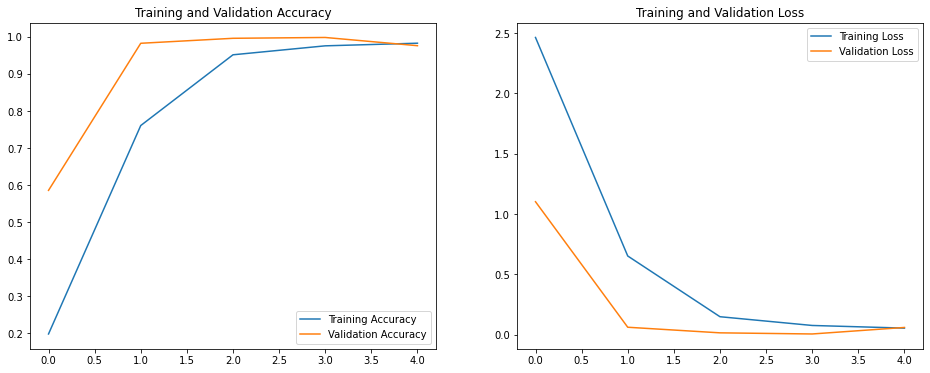

In [58]:
show_history(history)

Мы видим, что тонкая настройка показала впечатляющий результат: точность на контрольной выборке выросла на 3.3% и составила 99.5%. И это всего лишь за 5 эпох. Это связано с тем, что предобученная модель настраивалась на наборе данных, сильно отличающемся от того, на котором она обучивалась первоначально.

Теперь попробуем предобученную модель **Xception**. Это модификация сети Inception комании Google от создателя keras.

Размерность входного слоя для этой сети должна быть не менее 71x71, а количество каналов - строго 3. Поэтому преобразуем наши данные перед обучением.

In [ ]:
XCEP_IMG_HEIGHT = IMG_HEIGHT * 3
XCEP_IMG_WIDTH = IMG_WIDTH * 3

In [ ]:
xcep_train_data_gen = create_generator_for_transfer_learning(x_train, y_train, aug=True, target_size=(XCEP_IMG_HEIGHT, XCEP_IMG_WIDTH))
xcep_valid_data_gen = create_generator_for_transfer_learning(x_valid, y_valid, target_size=(XCEP_IMG_HEIGHT, XCEP_IMG_WIDTH))
xcep_test_data_gen = create_generator_for_transfer_learning(x_test, y_test, target_size=(XCEP_IMG_HEIGHT, XCEP_IMG_WIDTH))

In [17]:
xcep_net = keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(XCEP_IMG_HEIGHT, XCEP_IMG_WIDTH, 3))
xcep_net.trainable = False

model = keras.models.Sequential()
model.add(xcep_net)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='softmax'))

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                12825     
Total params: 30,312,001
Trainable params: 9,450,521
Non-trainable params: 20,861,480
_________________________________________________________________


In [18]:
EPOCHS = 15

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)

checkpoint = ModelCheckpoint(f'{DRIVE_DIR}cnn_xception_sign_mnist_weights.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

history = model.fit(
    xcep_train_data_gen, 
    epochs=EPOCHS,
    steps_per_epoch=total_train * 2 // BATCH_SIZE,
    workers=4,
    validation_data=xcep_valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    callbacks=[lr_reduction, checkpoint]
)

Epoch 1/15
343/343 [==============================] - ETA: 0s - loss: 0.8839 - accuracy: 0.7327
Epoch 00001: val_accuracy improved from -inf to 0.93211, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_xception_sign_mnist_weights.h5
343/343 [==============================] - 94s 273ms/step - loss: 0.8839 - accuracy: 0.7327 - val_loss: 0.2180 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 2/15
343/343 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.8558
Epoch 00002: val_accuracy improved from 0.93211 to 0.96271, saving model to /content/drive/My Drive/Colab Notebooks/6/cnn_xception_sign_mnist_weights.h5
343/343 [==============================] - 94s 273ms/step - loss: 0.4360 - accuracy: 0.8558 - val_loss: 0.1226 - val_accuracy: 0.9627 - lr: 0.0010
Epoch 3/15
343/343 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.8834
Epoch 00003: val_accuracy improved from 0.96271 to 0.96737, saving model to /content/drive/My Drive/Colab Notebooks

In [25]:
eval_model = keras.models.load_model(f'{DRIVE_DIR}cnn_xception_sign_mnist_weights.h5')
eval_model.evaluate(xcep_test_data_gen, steps=total_test // BATCH_SIZE, workers=4)

56/56 [==============================] - 10s 176ms/step - loss: 0.0841 - accuracy: 0.9723


[0.0840715691447258, 0.9723168611526489]

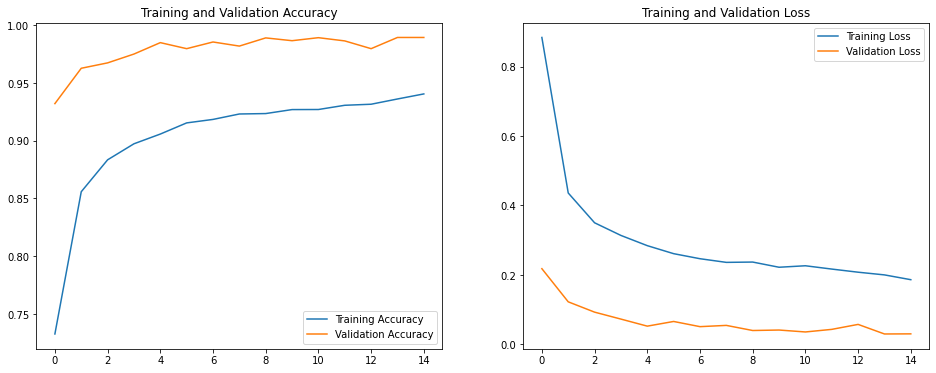

In [21]:
show_history(history)

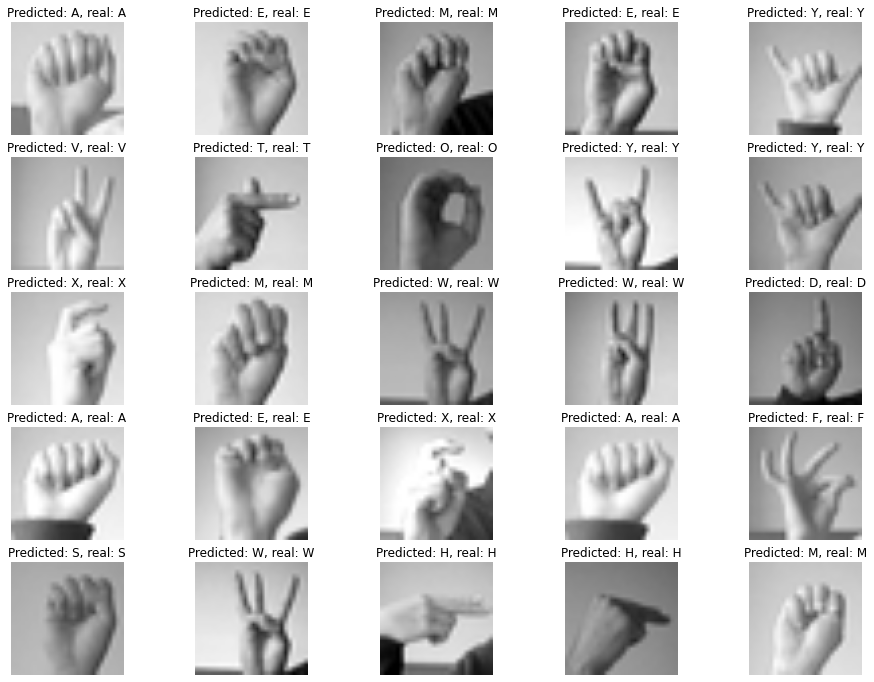

In [26]:
show_predictions(eval_model, xcep_test_data_gen)

Точность классификатора на контрольной выборке составила 97.2%, что меньше, чем на настроенной модели VGG16.

Исходя из проведённых экспериментов можно сделать вывод, что использование предобученных моделей даёт действительно неплохие результаты. А для достижения наилучшего результата можно применить тонкую настройку: чем сильнее набор данных, на котором обучалась модель первоначально, отличается от того, на котором модель настраивается, тем более высокой точности удастся достигнуть.

Самую высокую точность показала модель VGG16 с применением тонкой настройки: она составила 99.5%.